# Example usage of the ACCESS-NRI intake-dataframe-catalog

-----

The premise here is a (outer) catalog of (sub)catalogs, which each correspond to different "experiments". 

The idea is that users will:
 - query on metadata shared across the different subcatalogs to find the experiments that interest them
 - open those subcatalogs (which may have different/additional metadata than the outer catalog)
 - query further on the subcatalog(s) and eventually load some data

In [1]:
import intake

import matplotlib.pyplot as plt

In [2]:
cat = intake.open_catalog("/g/data/tm70/ds0092/projects/nri_intake_catalog/catalogs/dfcatalog.yaml").NRI

# We now have ~2 PB of data at our fingertips

In [3]:
cat

,model,description,realm,frequency,variable
subcatalog,,,,,
01deg_jra55v13_ryf9091,ACCESS-OM2,0.1 degree ACCESS-OM2 global model configuration with JRA55-do v1.3 RYF9091 repeat year forcing (May 1990 to Apr 1991),"[ice, ocean]","[1day, 1mon, 3hr, 3mon, fx]","[ANGLE, ANGLET, HTE, HTN, Tsfc_m, age_global, aice_m, aicen_m, alidf_ai_m, alidr_ai_m, alvdf_ai_m, alvdr_ai_m, area_t, area_u, average_DT, average_T1, average_T2, bih_fric_u, bih_fric_v, blkmask, ..."
01deg_jra55v140_iaf,ACCESS-OM2,Cycle 1/4 of 0.1 degree ACCESS-OM2 global model configuration with JRA55-do v1.4.0 OMIP2 interannual forcing,"[ice, ocean]","[1day, 1mon, fx]","[ANGLE, ANGLET, HTE, HTN, NCAT, Tsfc_m, age_global, aice, aice_m, aicen, aicen_m, alidf_ai_m, alidr_ai_m, alvdf_ai_m, alvdr_ai_m, area_t, area_u, average_DT, average_T1, average_T2, bih_fric_u, bi..."
01deg_jra55v140_iaf_cycle2,ACCESS-OM2,Cycle 2/4 of 0.1 degree ACCESS-OM2 global model configuration with JRA55-do v1.4.0 OMIP2 interannual forcing,"[ice, ocean]","[1day, 1mon, fx]","[ANGLE, ANGLET, HTE, HTN, NCAT, Sinz, Sinz_m, Tinz, Tinz_m, Tsfc_m, age_global, aice, aice_m, aicen, aicen_m, alidf_ai_m, alidr_ai_m, alvdf_ai_m, alvdr_ai_m, area_t, area_u, average_DT, average_T1..."
01deg_jra55v140_iaf_cycle3,ACCESS-OM2,Cycle 3/4 of 0.1 degree ACCESS-OM2 global model configuration with JRA55-do v1.4.0 OMIP2 interannual forcing,"[ice, ocean]","[1day, 1mon, fx]","[ANGLE, ANGLET, HTE, HTN, Sinz, Sinz_m, Tinz, Tinz_m, Tsfc_m, age_global, aice, aice_m, aicen_m, alidf_ai_m, alidr_ai_m, alvdf_ai_m, alvdr_ai_m, area_t, area_u, average_DT, average_T1, average_T2,..."
...,...,...,...,...,...
by647c,ACCESS-CM2,"Ensemble 4/5 of standard CMIP6 ssp245 simulation control experiment for by578c, branched from ACCESS-CM2 bx944c in 2015","[atmos, ice, ocean]","[1day, 1mon]","[ANGLE, ANGLET, NCAT, Tair, Tsfc, VGRDb, age_global, agm_grid_scaling, aice, aicen, alidf_ai, alidr_ai, alvdf_ai, alvdr_ai, anompb, apeff, apeff_ai, apeffn, apond, apond_ai, apondn, ardg, ardgn, a..."
by647d,ACCESS-CM2,"Ensemble 5/5 of standard CMIP6 ssp245 simulation control experiment for by578d, branched from ACCESS-CM2 bx944d in 2015","[atmos, ice, ocean]","[1day, 1mon]","[ANGLE, ANGLET, NCAT, Tair, Tsfc, VGRDb, age_global, agm_grid_scaling, aice, aicen, alidf_ai, alidr_ai, alvdf_ai, alvdr_ai, anompb, apeff, apeff_ai, apeffn, apond, apond_ai, apondn, ardg, ardgn, a..."
bz687,ACCESS-CM2,Present day control run,"[atmos, ice, ocean]","[1day, 1mon]","[ANGLE, ANGLET, NCAT, Tair, Tsfc, VGRDb, age_global, agm_grid_scaling, aice, aicen, alidf_ai, alidr_ai, alvdf_ai, alvdr_ai, anompb, apeff, apeff_ai, apeffn, apond, apond_ai, apondn, ardg, ardgn, a..."
cj877,ACCESS-CM2,Present day control run with ACCESS-OM2 0.25 deg ocean,"[atmos, ice, ocean]","[1day, 1mon, fx]","[ANGLE, ANGLET, NCAT, Tair, Tsfc, VGRDb, age_global, agm, aice, aicen, alidf_ai, alidr_ai, alvdf_ai, alvdr_ai, apeff, apeff_ai, apeffn, apond, apond_ai, apondn, ardg, ardgn, area_t, area_u, aredi,..."


# We can search on the columns in this catalog

In [4]:
cat2 = cat.search(model="ACCESS-ESM1-5")
cat2

,model,description,realm,frequency,variable
subcatalog,,,,,
CMIP6_CMS,ACCESS-ESM1-5,CMIP6 datasets catalogued by CLEX-CMS,"[atmos, ice, land, multi, ocean]","[1day, 1mon, 1yr, 3hr, 6hr]","[agessc, arag, baresoilFrac, bigthetao, bigthetaoga, c3PftFrac, c4PftFrac, cCwd, cLand, cLeaf, cLitter, cProduct, cRoot, cSoil, cSoilFast, cSoilMedium, cSoilSlow, cVeg, cWood, chl, chlos, cl, cli,..."
CMIP6_NCI_fs38,ACCESS-ESM1-5,Australian CMIP6-era datasets catalogued by NCI,"[atmos, ice, land, multi, ocean]","[1day, 1mon, 1yr, 3hr, 6hr, fx]","[agessc, arag, areacella, areacello, baresoilFrac, basin, bigthetao, bigthetaoga, c3PftFrac, c4PftFrac, cCwd, cLand, cLeaf, cLitter, cProduct, cRoot, cSoil, cSoilFast, cSoilMedium, cSoilSlow, cVeg..."
HI-C-05-r1,ACCESS-ESM1-5,"CMIP6 historical run, but with nitrogen and phosphorus limitations disabled within CASA-CNP","[atmos, ice, ocean]","[1day, 1mon, 1yr]","[ANGLE, ANGLET, NCAT, Tsfc, VGRDi, VGRDs, adic, age_global, agm_grid_scaling, aice, aicen, alk, anompb, arag_raw, area_t, area_u, atm_co2, average_DT, average_T1, average_T2, bmf_u, bmf_v, bottom_..."
HI-CN-05,ACCESS-ESM1-5,"CMIP6 historical run, but with phosphorus limitation disabled within CASA-CNP","[atmos, ice, ocean]","[1day, 1mon, 1yr, 3hr, 6hr]","[ANGLE, ANGLET, NCAT, Tsfc, VGRDi, VGRDs, adic, age_global, agm_grid_scaling, aice, aicen, alk, anompb, arag_raw, area_t, area_u, atm_co2, average_DT, average_T1, average_T2, bmf_u, bmf_v, bottom_..."
...,...,...,...,...,...
PI-GWL-B2050,ACCESS-ESM1-5,"Climate stabilization run at different global warming levels with zero C02 emissions and pre-industrial aerosols, branched from ACCESS-ESM1.5 SSP-EDC-585-13 in 2050","[atmos, ice, ocean]","[1day, 1mon, 1yr]","[ANGLE, ANGLET, Tsfc, VGRDi, VGRDs, adic, age_global, agm_grid_scaling, aice, aicen, alk, anompb, arag_raw, area_t, area_u, atm_co2, average_DT, average_T1, average_T2, bmf_u, bmf_v, bottom_age_gl..."
PI-GWL-B2055,ACCESS-ESM1-5,"Climate stabilization run at different global warming levels with zero C02 emissions and pre-industrial aerosols, branched from ACCESS-ESM1.5 SSP-EDC-585-13 in 2055","[atmos, ice, ocean]","[1day, 1mon, 1yr]","[ANGLE, ANGLET, Tsfc, VGRDi, VGRDs, adic, age_global, agm_grid_scaling, aice, aicen, alk, anompb, arag_raw, area_t, area_u, atm_co2, average_DT, average_T1, average_T2, bmf_u, bmf_v, bottom_age_gl..."
PI-GWL-B2060,ACCESS-ESM1-5,"Climate stabilization run at different global warming levels with zero C02 emissions and pre-industrial aerosols, branched from ACCESS-ESM1.5 SSP-EDC-585-13 in 2060","[atmos, ice, ocean]","[1day, 1mon, 1yr]","[ANGLE, ANGLET, Tsfc, VGRDi, VGRDs, adic, age_global, agm_grid_scaling, aice, aicen, alk, anompb, arag_raw, area_t, area_u, atm_co2, average_DT, average_T1, average_T2, bmf_u, bmf_v, bottom_age_gl..."
PI_GWL_B2035,ACCESS-ESM1-5,"Climate stabilization run at different global warming levels with zero C02 emissions and pre-industrial aerosols, branched from ACCESS-ESM1.5 SSP-EDC-585-13 in 2035","[atmos, ice, ocean]","[1day, 1mon, 1yr]","[ANGLE, ANGLET, Tsfc, VGRDi, VGRDs, adic, age_global, agm_grid_scaling, aice, aicen, alk, anompb, arag_raw, area_t, area_u, atm_co2, average_DT, average_T1, average_T2, bmf_u, bmf_v, bottom_age_gl..."


### We can combine queries in a search

In [5]:
cat3 = cat.search(model="ACCESS-ESM1-5", variable="tos", frequency="1mon")
cat3

,model,description,realm,frequency,variable
subcatalog,,,,,
CMIP6_CMS,ACCESS-ESM1-5,CMIP6 datasets catalogued by CLEX-CMS,ocean,1mon,"[agessc, arag, bigthetao, bigthetaoga, chl, chlos, detoc, detocos, dfe, dfeos, dissic, dissicnat, dissicnatos, dissicos, eparag100, epc100, evs, fgco2, fgco2nat, fgo2, friver, fsitherm, hfbasinpma..."
CMIP6_NCI_fs38,ACCESS-ESM1-5,Australian CMIP6-era datasets catalogued by NCI,ocean,1mon,"[agessc, arag, bigthetao, bigthetaoga, chl, chlos, detoc, detocos, dfe, dfeos, dissic, dissicnat, dissicnatos, dissicos, eparag100, epc100, evs, fgco2, fgco2nat, fgo2, friver, fsitherm, hfbasinpma..."


# This makes for quite a useful data-discovery tool
### E.g. for the CMIP6 intake-esm catalogs which contain lots of models

In [6]:
cat.search(subcatalog="CMIP6_CMS")

,model,description,realm,frequency,variable
subcatalog,,,,,
CMIP6_CMS,"[ACCESS-CM2, ACCESS-ESM1-5, ACCESS-OM2, ACCESS-OM2-025, AWI-CM-1-1-MR, AWI-ESM-1-1-LR, BCC-CSM2-HR, BCC-CSM2-MR, BCC-ESM1, CAMS-CSM1-0, CAS-ESM2-0, CESM1-1-CAM5-CMIP5, CESM1-CAM5-SE-HR, CESM1-CAM5...",CMIP6 datasets catalogued by CLEX-CMS,"[atmos, ice, land, multi, ocean]","[1day, 1hr, 1mon, 1yr, 3hr, 6hr, subhr]","[abs550aer, agessc, albisccp, arag, aragos, baresoilFrac, bigthetao, bigthetaoga, bldep, burntFractionAll, c3PftFrac, c4PftFrac, cCwd, cLand, cLeaf, cLitter, cLitterAbove, cLitterBelow, cLitterCwd..."


### Only one model is available with the variable `burntFractionAll`

In [7]:
cat.search(subcatalog="CMIP6_CMS", variable="burntFractionAll")

,model,description,realm,frequency,variable
subcatalog,,,,,
CMIP6_CMS,EC-Earth3-Veg,CMIP6 datasets catalogued by CLEX-CMS,land,1mon,"[baresoilFrac, burntFractionAll, cCwd, cLeaf, cLitter, cLitterAbove, cLitterBelow, cProduct, cRoot, cSoilFast, cSoilMedium, cSoilSlow, cVeg, cropFrac, evspsblsoi, evspsblveg, fFire, fGrazing, fHar..."


# Remember this is a catalog of catalogs

### Once we've sufficiently refined our search, we can load the (intake-esm) subcatalog

In [8]:
subcat = cat.search(subcatalog="025deg_jra55_iaf_omip2_cycle1").to_subcatalog()

subcat

,unique
path,1830
realm,2
variable,288
filename,1470
...,...
start_date,855
end_date,793
frequency,4
derived_variable,0


In [9]:
subcat.keys()

['iceh.1mon',
 'iceh_daily.1day',
 'ocean_budget.1yr',
 'ocean_daily.1day',
 'ocean_grid.fx',
 'ocean_month.1mon',
 'ocean_scalar.1mon',
 'ocean_scalar_snapshot.1day']

### We can search in this intake-esm subcatalog

In [10]:
subcat2 = subcat.search(variable="temp_global_ave")

subcat2.keys()

['ocean_scalar.1mon', 'ocean_scalar_snapshot.1day']

### We're ready to load and analyse some data so let's start a dask cluster

In [11]:
from distributed import Client

client = Client(threads_per_worker=1)
client.dashboard_link

'http://127.0.0.1:8787/status'

In [12]:
ds_dict = subcat2.to_dataset_dict(progressbar=False)

In [13]:
ds_dict

{'ocean_scalar.1mon': <xarray.Dataset>
 Dimensions:          (time: 732, scalar_axis: 1)
 Coordinates:
   * scalar_axis      (scalar_axis) float64 0.0
   * time             (time) datetime64[ns] 1958-01-14T12:00:00 ... 2018-12-14...
 Data variables:
     temp_global_ave  (time, scalar_axis) float32 dask.array<chunksize=(12, 1), meta=np.ndarray>
 Attributes:
     filename:                        ocean_scalar.nc
     title:                           ACCESS-OM2
     grid_type:                       mosaic
     grid_tile:                       1
     intake_esm_vars:                 ['temp_global_ave']
     intake_esm_attrs:realm:          ocean
     intake_esm_attrs:variable:       total_mass_seawater,total_volume_seawate...
     intake_esm_attrs:filename:       ocean_scalar
     intake_esm_attrs:file_id:        ocean_scalar
     intake_esm_attrs:frequency:      1mon
     intake_esm_attrs:_data_format_:  netcdf
     intake_esm_dataset_key:          ocean_scalar.1mon,
 'ocean_scalar_snapsh

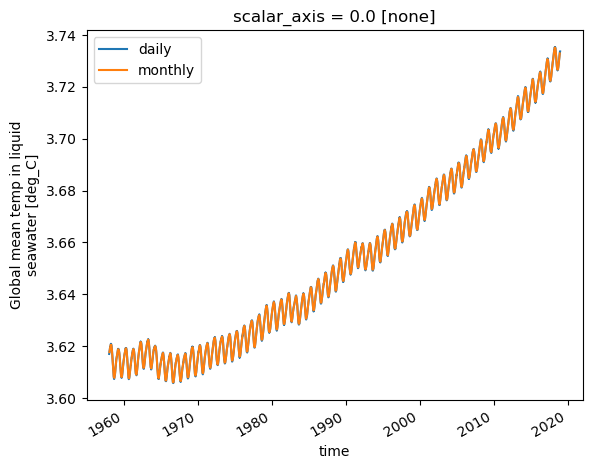

In [14]:
ds_dict["ocean_scalar_snapshot.1day"]["temp_global_ave"].plot(label="daily")
ds_dict["ocean_scalar.1mon"]["temp_global_ave"].plot(label="monthly")

_ = plt.legend()

# A full example workflow

Let's compare SST fields from:
- ACCESS-OM2, `1deg_jra55_iaf_omip2_cycle1`
- ACCESS-ESM1.5, `HI-C-05-r1`
- ACCESS-CM2, `bx944`

-----

In [15]:
cat4 = cat.search(subcatalog=["1deg_jra55_iaf_omip2_cycle1", "HI-C-05-r1", "bx944"])

cat4

,model,description,realm,frequency,variable
subcatalog,,,,,
1deg_jra55_iaf_omip2_cycle1,ACCESS-OM2,Cycle 1/6 of 1 degree ACCESS-OM2-BGC global configuration with JRA55-do v1.4 OMIP2 interannual forcing (1958-2019),"[ice, ocean]","[1day, 1mon, 1yr, fx]","[ANGLE, ANGLET, HTE, HTN, NCAT, Tair_m, Tsfc_m, adic, age_global, agm, aice, aice_m, aicen_m, aiso_bih, albice_m, albsni_m, albsno_m, alidf_ai_m, alidr_ai_m, alk, alvdf_ai_m, alvdr_ai_m, area_t, a..."
HI-C-05-r1,ACCESS-ESM1-5,"CMIP6 historical run, but with nitrogen and phosphorus limitations disabled within CASA-CNP","[atmos, ice, ocean]","[1day, 1mon, 1yr]","[ANGLE, ANGLET, NCAT, Tsfc, VGRDi, VGRDs, adic, age_global, agm_grid_scaling, aice, aicen, alk, anompb, arag_raw, area_t, area_u, atm_co2, average_DT, average_T1, average_T2, bmf_u, bmf_v, bottom_..."
bx944,ACCESS-CM2,"Ensemble 1/5 of standard CMIP6 historical simulation control experiment for by473, branched from ACCESS-CM2 bi889","[atmos, ice, ocean]","[1day, 1mon]","[ANGLE, ANGLET, NCAT, Tair, Tsfc, VGRDb, age_global, agm_grid_scaling, aice, aicen, alidf_ai, alidr_ai, alvdf_ai, alvdr_ai, anompb, apeff, apeff_ai, apeffn, apond, apond_ai, apondn, ardg, ardgn, a..."


In [16]:
subcat_dict = cat4.to_subcatalog_dict()

subcat_dict

{'1deg_jra55_iaf_omip2_cycle1': <1deg_jra55_iaf_omip2_cycle1 catalog with 11 dataset(s) from 2013 asset(s)>,
 'HI-C-05-r1': <HI-C-05-r1 catalog with 11 dataset(s) from 7873 asset(s)>,
 'bx944': <bx944 catalog with 7 dataset(s) from 2430 asset(s)>}

In [17]:
xarray_open_kwargs = dict(
    use_cftime=True,
)
xarray_combine_by_coords_kwargs = dict(
    compat="override",
    data_vars="minimal", 
    coords="minimal",
)
    
ds_dict = {
    name: subcat.search(
        realm="ocean",
        variable="sst",
        frequency="1mon"
    ).to_dask(
        xarray_open_kwargs=xarray_open_kwargs, 
        xarray_combine_by_coords_kwargs=xarray_combine_by_coords_kwargs
    ) 
    for name, subcat in subcat_dict.items()
}

In [18]:
def plot_time(ds_dict, time):
    """ Plot monthly SST at a provided time """
    nrows = len(ds_dict)
    fig = plt.figure(figsize=(8, nrows*3))
    axs = fig.subplots(nrows,1)
    fig.suptitle(f'Monthly SST, {time}')
    
    for idx, (name, ds) in enumerate(ds_dict.items()):
        ax = axs[idx]
        data = ds["sst"].sel(time=time).compute()
        if (data > 273.15).any().item():
            data -= 273.15
        data.plot(ax=ax, cmap="viridis", vmin=-2, vmax=30)
        ax.set_title(name)
        ax.set_xlabel("")
        ax.set_ylabel("")
        
    fig.tight_layout()

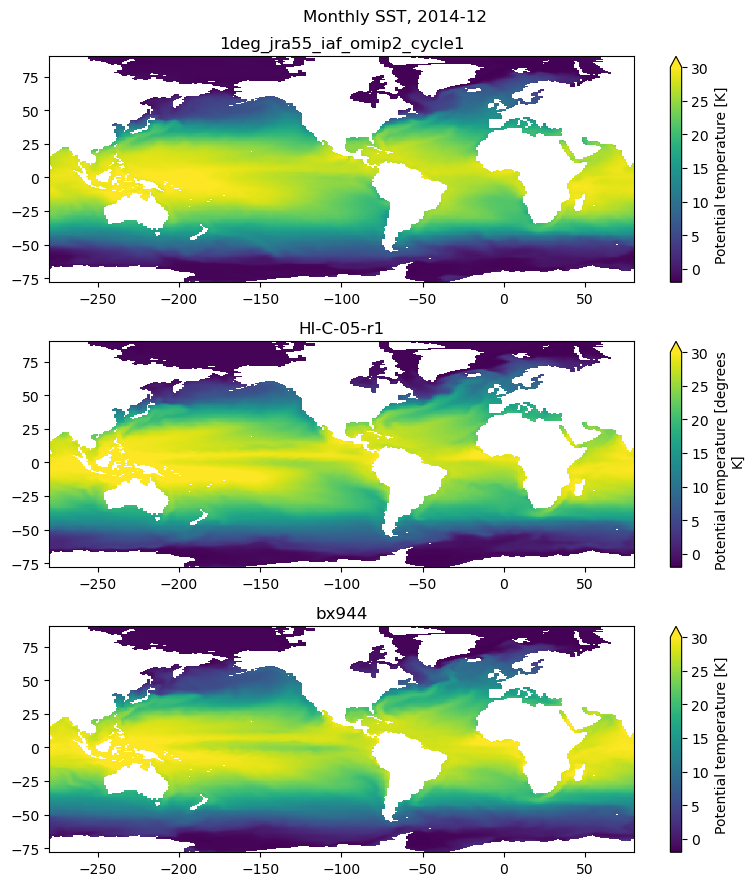

In [19]:
plot_time(ds_dict, time="2014-12")

# Actually, I also want to add some data from CMIP6

In [20]:
cmip_subcat = cat.search(subcatalog="CMIP6_CMS").to_subcatalog()

In [21]:
ds = cmip_subcat.search(
    source_id="ACCESS-ESM1-5", 
    table_id="Omon", 
    variable_id="tos", 
    experiment_id="historical", 
    member_id="r1i1p1f1"
).to_dask()

ds_dict["CMIP6 ACCESS-ESM1.5 historical"] = ds.rename({"tos": "sst"})

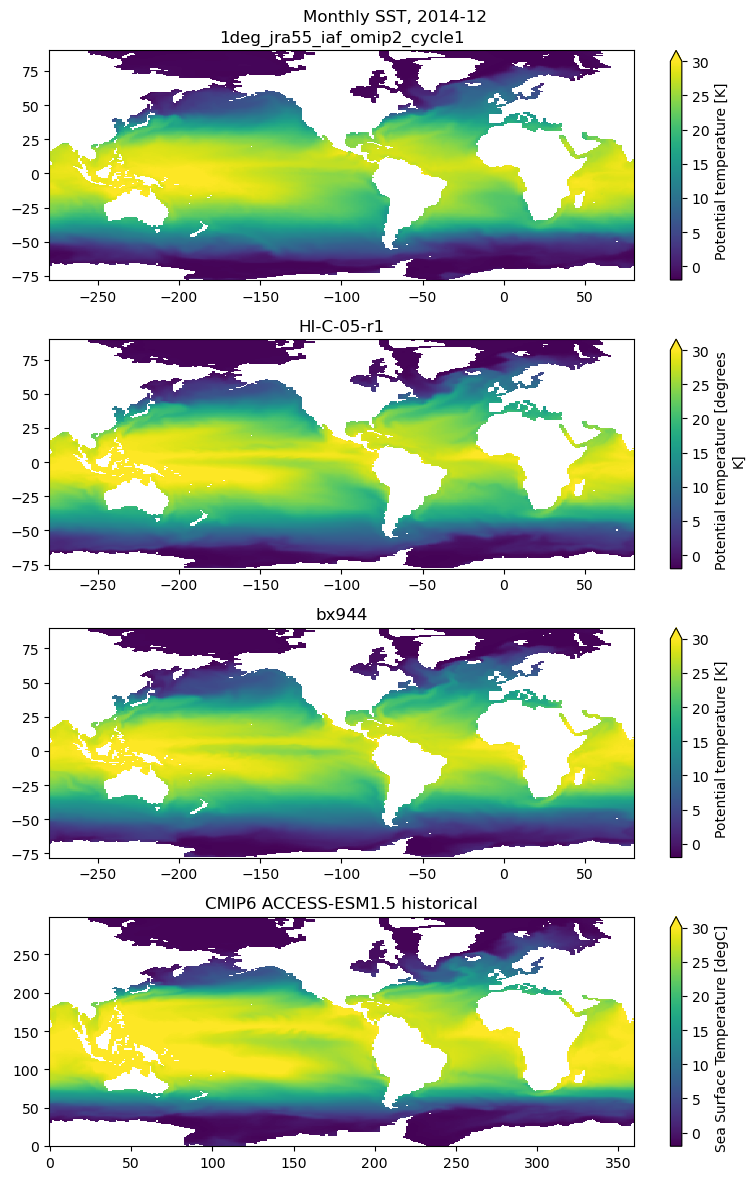

In [22]:
plot_time(ds_dict, time="2014-12")

In [24]:
client.close()